# Lista 4 - Redes Neurais Artificiais

## Sumário

-   Questão 1: [A](#Questão-1-a.), [B](#Questão-1-b.)
-   Questão 2: [A](#Questão-2-a.), [B](#Questão-2-b.)

<span style="position: absolute; top: 10px; right: 10px; background: green; padding: 0.5em; color: white; border-radius: 8px; font-weight: bold">Vaux Gomes</span>

## Implementações

### Importações


In [560]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### MinMax Normalizer

In [891]:
class MinMax():
    ''' MinMax Normalizer '''

    #
    def fit_transform(self, X):
        self.min = X.min(axis=0)
        self.max = X.max(axis=0)
        
        return (X - self.min)/(self.max - self.min)
    
    #
    def transform(self, X):
        return (X - self.min)/(self.max - self.min)
    
    #
    def restore(self, X):
        return X*(self.max - self.min) + self.min

### Loading

In [924]:
# Importação dos conjuntos de dados
data = np.genfromtxt('concrete.csv', delimiter=',')

X = data[:, :-1]
y = data[:, -1:]

# [Train, Valid] + Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]*0.2), random_state=42)

# Normalizer
normalizer = MinMax()
#
X_train = normalizer.fit_transform(X_train)
X_test  = normalizer.transform(X_test) # Avoiding contamination

# Train + Valid already normalized
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=int(X.shape[0]*0.2), random_state=42)

print(f'Concrete: {X.shape}, {y.shape}')
print(f'   Train: {X_train.shape}, {y_train.shape}')
print(f'    Test: {X_test.shape }, {y_test.shape }')
print(f'   Valid: {X_valid.shape}, {y_valid.shape}')

Concrete: (1030, 8), (1030, 1)
   Train: (618, 8), (618, 1)
    Test: (206, 8), (206, 1)
   Valid: (206, 8), (206, 1)


### Rectified Linear Units Function (ReLU)

In [556]:
class ReLU():
    ''' Rectified Linear Units Function '''
    
    #
    def transfer(x): 
        ''' ReLU Function '''
        return x * (x > 0)
        
    #
    def derivative(x): 
        ''' Derivative '''
        return 1 * (x > 0)
    
    #
    def __str__():
        return 'ReLU'

### MLP

Shape     : (8, 8, 1)
Ephochs   : 1000
Batch Size: 32


(0.0, 100.0)

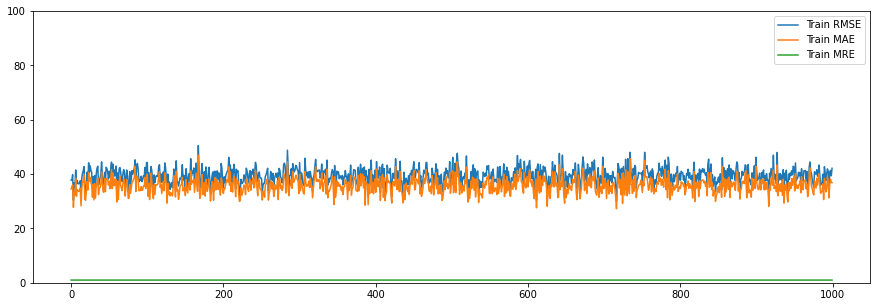

In [941]:
class MultilayerPerceptron:
    
    #
    def __init__(self, shape, epochs=300, batch_size=0.1, learning_rate=0.1, activation=ReLU, momentum=0.5, seed=42):
        #
        np.random.seed(seed)
        
        #
        self.shape = shape
        self.size = len(shape) - 1
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.activation = activation
        self.momentum = momentum
        
        #
        self.weights = []
        self.pwdelta = []
        
        #
        for (l1, l2) in zip(shape[:-1], shape[1:]):
            # print(l1, l2)
            self.weights.append(np.random.normal(scale=0.1, size=(l2, l1 + 1)))
            self.pwdelta.append(np.zeros((l2, l1 + 1)))

    #
    def fit(self, X, y):        
        #
        self.errors = { 'train': { 'rmse': [], 'mae': [], 'mre': [] } }
        
        #
        indexes = np.arange(0, X.shape[0])
        
        #
        batch_size = int(self.batch_size * X.shape[0]) if type(self.batch_size) == float else self.batch_size
        batch_size = min(batch_size, X.shape[0])
        
        #
        print(f'Shape     : {self.shape}')
        print(f'Ephochs   : {self.epochs}')
        print(f'Batch Size: {batch_size}')
        
        # EPOCHS
        for e in range(self.epochs):
            #
            linputs  = [] # Layer input
            loutputs = [] # Layer output
            deltas   = []
            
            # Batch with replacement
            np.random.shuffle(indexes)
            
            X_batch = X[indexes[:batch_size]]
            y_batch = y[indexes[:batch_size]]
            
            #
            m, n = X_batch.shape

            # Forward        
            for idx in range(self.size):
                # First
                if idx == 0:
                    linput = self.weights[idx].dot(np.vstack([X_batch.T, np.ones([1, m])]))
                else:
                    linput = self.weights[idx].dot(np.vstack([linputs[-1], np.ones([1, m])]))

                #
                linputs.append(linput)
                loutputs.append(self.activation.transfer(linput))

            # Backward
            for idx in reversed(range(self.size)):
                # Last
                if idx == self.size - 1:
                    # Difference from the target
                    output_delta = loutputs[idx] - y_batch.T
                    deltas.append(output_delta * self.activation.derivative(linputs[idx]))
                    
                    # Train errors
                    self.errors['train']['rmse'].append(np.sqrt((output_delta**2).mean()))
                    self.errors['train']['mae'].append(np.abs(output_delta).mean())
                    self.errors['train']['mre'].append(np.abs(output_delta/y_batch.T).mean())
                    
                else:
                    # Difference from next layer's delta
                    delta_pullback = self.weights[idx + 1].T.dot(deltas[-1])
                    deltas.append(delta_pullback[:-1, :] * self.activation.derivative(linputs[idx]))

            # Weight update
            for idx in range(self.size):
                delta_idx = self.size - 1 - idx
                
                # Input layer
                if idx == 0:
                    loutput = np.vstack([X_batch.T, np.ones([1, m])])
                else:
                    loutput = np.vstack([
                        loutputs[idx - 1], 
                        np.ones([1, loutputs[idx - 1].shape[1]])])
                    
                #   
                curr_wdelta = np.sum(
                    loutput[None, :, :].transpose(2, 0, 1) * 
                    deltas[delta_idx][None, :, :].transpose(2, 1, 0),
                    axis = 0
                )
                
                #
                wdelta = self.learning_rate * curr_wdelta + self.momentum * self.pwdelta[idx]
                
                # Update
                self.weights[idx] -= wdelta
                self.pwdelta[idx] = wdelta
            
    #
    def __repr__(self):
        return str(self.shape)
        
# MODEL
model = MultilayerPerceptron((X_train.shape[1], 8, 1), epochs=1000, batch_size=2**5)
model.fit(X_train, y_train)

# PLOT
plt.figure(figsize=(15, 5))

_ = plt.plot(model.errors['train']['rmse'], label="Train RMSE")
_ = plt.plot(model.errors['train']['mae' ], label="Train MAE" )
_ = plt.plot(model.errors['train']['mre' ], label="Train MRE" )

plt.legend()
plt.ylim((0, 100))

In [890]:
X_train

array([[ 190.3,    0. ,  125.2, ..., 1088.1,  802.6,   28. ],
       [ 389.9,  189. ,    0. , ...,  944.7,  755.8,   91. ],
       [ 229.7,    0. ,  118.2, ..., 1028.1,  757.6,   56. ],
       ...,
       [ 181.4,    0. ,  167. , ..., 1055.6,  777.8,   14. ],
       [ 397. ,    0. ,    0. , ..., 1040. ,  734. ,   28. ],
       [ 277.2,   97.8,   24.5, ..., 1061.7,  782.5,   56. ]])